<a href="https://colab.research.google.com/github/LudwigBitHoven/Dostoevsky-shenanigans/blob/main/Dostoevsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dostoevsky
!pip install pymorphy2
!python -m dostoevsky download fasttext-social-network-model

In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import pymorphy2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Прочитаем датафрейм, удалим лишние столбцы и лишние спарсенные значения
morph = pymorphy2.MorphAnalyzer()
df_comments = pd.read_csv('comments.csv')
df_comments = df_comments.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
df_comments = df_comments.dropna()
df_comments.head()
print(f"Выборка составляет {df_comments.shape[0]}")

Выборка составляет 3120


In [ ]:
"""
  В вк не все пользователи имеют имя и фамилию написанные кириллицей, в силу этого pymorphy (работающий толко с кириллицей) не
  может определить пол автора сообщения по паре значений фамилия-имя, чтобы решить эту проблему напишем код переводящий транслит в кириллицу
"""
de_transliterate_dict_complex = {
    'b': 'б', 'v': 'в', 'g': 'г', 'd': 'д',
    'yo': 'ё', 'zh': 'ж', 'ai': 'ай',
    'j': 'й', 'k': 'к', 'l': 'л', 'm': 'м', 'n': 'н',
    'o': 'о', 'r': 'р', 'f': 'ф', 'ch': 'ч',
    'sch': 'щ', 'eh': 'э', 'yu': 'ю', 'ya': 'я', 'iy': 'ий',
    'sh': 'ш', 'w': 'в', 'ye': 'ьe', 'oo': 'у', 'th': 'т', 'ph': 'ф'
}
de_transliterate_simple = {
    'ts': 'ц', 'z': 'з', 's': 'с',
    'h': 'х', 'u': 'у', 'y': 'ы',
    'a': 'а', 'e': 'е', 'c': 'к',
    't': 'т', 'i': 'и', 'p': 'п'
}

def get_de_transiletrated_name(word):
  word = word.lower()
  if " " in word:
    word = word.split()
  else:
    word = [word]
  res = ''
  for i in word:
    for j in de_transliterate_dict_complex.keys():
      i = i.replace(j, de_transliterate_dict_complex[j])
    for j in de_transliterate_simple.keys():
      i = i.replace(j, de_transliterate_simple[j])
    res += i + ' '
  return res
print(get_de_transiletrated_name('nikolai chaptykov'))



николай чаптыков 


In [ ]:
# Данное решение может выдавать ошибки, но в рамках этой работы оно хорошо снижает количество неопределенных пользователей
test_names = ['Nikolai Chaptykov', 'Elizaveta Ivenkova', 'Taisiya Lem',
              'Fyodor Letz', 'Yuliya Ermolaeva', 'Lyudmila blagorodnaya',
              'Mark Twain', 'Taylor Swift', 'Phil Anselmo']
for i in test_names:
  print(f"{i} -> {get_de_transiletrated_name(i)}")

Nikolai Chaptykov -> николай чаптыков 
Elizaveta Ivenkova -> елизавета ивенкова 
Taisiya Lem -> тайсия лем 
Fyodor Letz -> фёдор летз 
Yuliya Ermolaeva -> юлия ермолаева 
Lyudmila blagorodnaya -> людмила благородная 
Mark Twain -> марк твайн 
Taylor Swift -> таылор свифт 
Phil Anselmo -> фил анселмо 


In [ ]:
# Выделим всех авторов комментариев с латинскими именами и применим к ним де-транслит функцию
messages = df_comments['text'].tolist()
author = df_comments['author'].tolist()
for i in range(len(author)):
  if author[i].isascii():
    author[i] = get_de_transiletrated_name(author[i])

In [ ]:
"""
  Напишем функцию для определения пола автора с помощью библиотеки pymorphy
"""
def get_sex_author(word):
  if " " in word:
    word = word.split()
  for i in word:
    temp = morph.parse(i)[0]
    if temp.tag.gender == 'femn':
      return 'Женский'
    elif temp.tag.gender == 'masc':
      return 'Мужской'
  return np.nan

In [ ]:
"""
  Приготовим датафрейм
"""
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

mood = ('negative', 'positive')
default_set = set(mood)

results = model.predict(messages, k=2) # загружаем сообщения в dostoevsky
skip_list, neutral_list, sum_list, formal_list, sex, author_temp = [], [], [], [], [], []
cnt = 0
for message, sentiment in zip(messages, results):
    temp_sentiment = set([i for i in sentiment.keys()]) & default_set
    sum = 0
    for i in temp_sentiment: # объединим positive и negative в один показатель
        if i == 'negative':
          sum -= sentiment[i] # если negative, то декрементируем
        if i == 'positive':
          sum += sentiment[i] # если positive, то инкрементируем
    sum_list.append(sum)
    neutral_list.append(sentiment['neutral'] if sentiment.get('neutral') else 0) # запишем нейтральность сообщения
    skip_list.append(sentiment['skip'] if sentiment.get('skip') else 0) # запишем сложность классификации сообщения
    formal_list.append(sentiment['speech'] if sentiment.get('speech') else 0) # запишем формальность сообщения
    sex.append(get_sex_author(author[cnt]))
    author_temp.append(author[cnt])
    cnt += 1

df = pd.DataFrame(
    {'Сообщение': messages,
     'Доброжелательность': sum_list,
     'Нейтральность': neutral_list,
     'Формальность': formal_list,
     'Сложность': skip_list,
     'Пол': sex,
     'Автор': author},)
df

,Сообщение,Доброжелательность,Нейтральность,Формальность,Сложность,Пол,Автор
0,"эта была немного другой, юмор разбавили, туале...",-0.022111,0.000000,0.0,0.000000,Женский,Ирина Бабикова
1,gif6.7 МБ,0.000000,0.997459,0.0,0.007356,Мужской,Виктор Троневский
2,чёт этот кас больно шустрый в плане анимаций. ...,-0.468801,0.320831,0.0,0.000000,Мужской,мадйерк форевер
3,"Действительно забавно, когда видишь такое, что...",-0.268951,0.445540,0.0,0.000000,Мужской,Фёдр Кононенко
4,"Да Майку норм, он же искренне радовался что хо...",-0.136618,0.000000,0.0,0.294225,Мужской,мадйерк форевер
...,...,...,...,...,...,...,...
3115,Аниматрон превью,0.000000,0.989682,0.0,0.030225,Мужской,кирилл коновалов
3116,Не совсем понимаю как выходят эти серии? (муль...,-0.160276,0.705795,0.0,0.000000,NaN,сыриx ван-стыx
3117,Юмор фанатов хазбина такой типа,0.182436,0.000000,0.0,0.320831,Мужской,Леонид Курилов
3118,Когда-нибудь человечество объединится в стремл...,-0.637041,0.341593,0.0,0.000000,Мужской,Данила Близнюк


In [ ]:
# Определить пол для всех не удалось, ниже приведены исключения
df[df['Пол'].isna()].head()

,Сообщение,Доброжелательность,Нейтральность,Формальность,Сложность,Пол,Автор
21,Наконец-то сериал про средневозрастного персон...,0.191943,0.737168,0.0,0.000000,NaN,саша саша
22,"Довольно жиизнеутверждающий сирич, даже без ко...",0.445540,0.245095,0.0,0.000000,NaN,саша саша
84,"*Энергия покоя фотона равна нулю, потому что о...",-0.187143,0.672342,0.0,0.000000,NaN,Мотоко Кусанаги
184,"Ну давайте, пошутите про порно",-0.160276,0.961544,0.0,0.000000,NaN,ฺฺ ฺฺ
193,Храмовники против космоволков?,0.000000,0.959164,0.0,0.125933,NaN,アントン アントン


In [ ]:
df_male = df[df['Пол'] == 'Мужской'] # подготовим датафреймы по полам
df_female = df[df['Пол'] == 'Женский']
df_nan = df[df['Пол'].isna()]

Text(0.5, 1.0, 'Количество комментариев по полам')

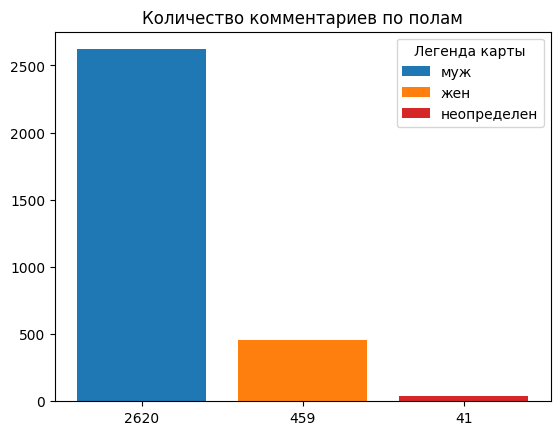

In [ ]:
values = [df_male.shape[0], df_female.shape[0], df_nan.shape[0]]
labels = [f"{i}" for i in values]
fig, ax = plt.subplots()
bar_colors = ['tab:blue', 'tab:orange', 'tab:red']
bar_label = ['муж', 'жен', 'неопределен']
ax.bar(labels, values, label=bar_label, color=bar_colors)
ax.legend(title='Легенда карты')
ax.set_title('Количество комментариев по полам')

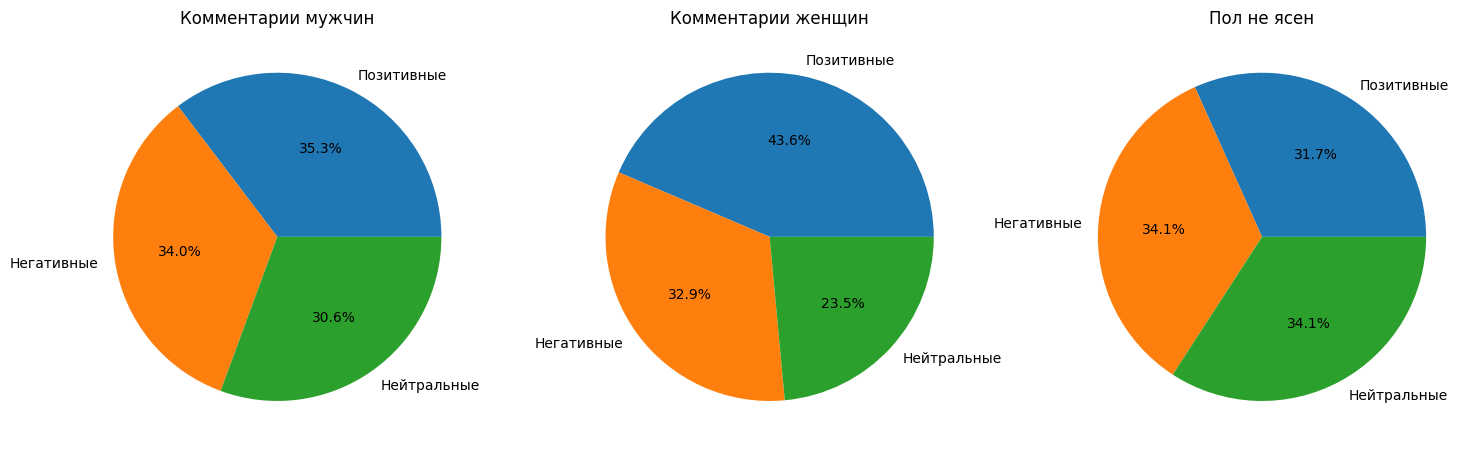

In [ ]:
positive = df_male[df_male['Доброжелательность'] > 0].shape[0] # получаем типы комментариев мужчин
negative = df_male[df_male['Доброжелательность'] < 0].shape[0]
neutral = df_male[df_male['Доброжелательность'] == 0].shape[0]
labels = ['Позитивные', 'Негативные', 'Нейтральные']
values = [positive, negative, neutral]
fig, ax = plt.subplots(ncols=3, figsize=(18, 12))
ax[0].set_title('Комментарии мужчин')
ax[0].pie(values, labels=labels, autopct='%1.1f%%')
positive = df_female[df_female['Доброжелательность'] > 0].shape[0] # получаем типы комментариев женщин
negative = df_female[df_female['Доброжелательность'] < 0].shape[0]
neutral = df_female[df_female['Доброжелательность'] == 0].shape[0]
values = [positive, negative, neutral]
ax[1].set_title('Комментарии женщин')
ax[1].pie(values, labels=labels, autopct='%1.1f%%')
positive = df_nan[df_nan['Доброжелательность'] > 0].shape[0] # получаем комментарии, где пол не получилось определить
negative = df_nan[df_nan['Доброжелательность'] < 0].shape[0]
neutral = df_nan[df_nan['Доброжелательность'] == 0].shape[0]
values = [positive, negative, neutral]
ax[2].set_title('Пол не ясен')
ax[2].pie(values, labels=labels, autopct='%1.1f%%')
plt.show()

Text(0.5, 1.0, 'Зависимость нейтральности сообщения от сложности определения его окраски')

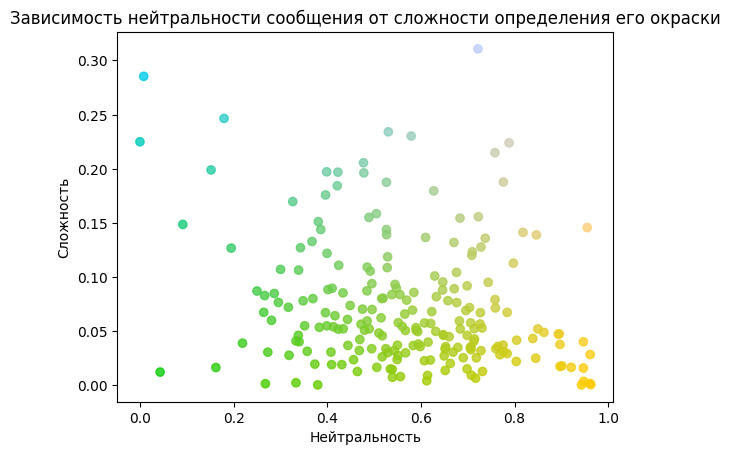

In [ ]:
"""
  В процессе тестирования dostoevsky возникла гипотеза, что библиотеке сложно классифицировать все нейтральные сообщения, следовательно для
  наиболее нейтральных по окраске сообщений должна быть повышенная сложность определения, проверим эту гипотезу
"""
df_authors = df.groupby('Автор')[
    ['Доброжелательность', 'Нейтральность', 'Сообщение', 'Сложность', 'Формальность']
    ].agg(
        {'Сообщение': ['count'], 'Доброжелательность' : ['mean'], 'Нейтральность' : ['mean'], 'Формальность': ['mean'], 'Сложность': ['mean']}
        ).sort_values(by=('Сообщение', 'count'))

dff = df_authors[(df_authors[('Сообщение', 'count')] > 2) & (df_authors[('Сложность', 'mean')])]
x = dff[('Нейтральность', 'mean')].tolist()
y = dff[('Сложность', 'mean')].tolist()
colors = []
y_max = max(y)
x_max = max(x)
for i, j in zip(x, y):
  colors.append((i / x_max, 0.8, j / y_max, 0.8))
plt.scatter(x, y, c=colors)
plt.xlabel("Нейтральность")
plt.ylabel("Сложность")
plt.title('Зависимость нейтральности сообщения от сложности определения его окраски')

In [ ]:
from scipy.stats import norm
import statistics

(array([0.03327065, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.19962387, 0.06654129, 0.46578904, 0.56560097,
        1.19774324, 1.66353228, 2.06278003, 2.46202777, 1.79661486,
        0.89830743, 0.53233033, 0.59887162, 0.39924775, 0.43251839,
        0.23289452, 0.13308258, 0.06654129, 0.06654129, 0.03327065]),
 array([-0.95258415, -0.88067858, -0.80877302, -0.73686746, -0.6649619 ,
        -0.59305633, -0.52115077, -0.44924521, -0.37733964, -0.30543408,
        -0.23352852, -0.16162296, -0.08971739, -0.01781183,  0.05409373,
         0.1259993 ,  0.19790486,  0.26981042,  0.34171598,  0.41362155,
         0.48552711,  0.55743267,  0.62933824,  0.7012438 ,  0.77314936,
         0.84505492]),
 <BarContainer object of 25 artists>)

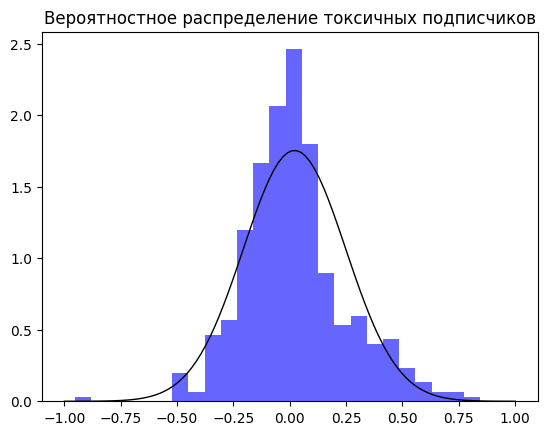

In [ ]:
dff = df_authors[(df_authors[('Сообщение', 'count')] > 1)]
dff
y = dff[('Доброжелательность', 'mean')].tolist()[:-10]

mu, std = norm.fit(y)
x = np.linspace(-1, 1, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=1)
plt.title('Вероятностное распределение токсичных подписчиков')
plt.hist(y, bins=25, density=True, alpha=0.6, color='b')

Text(0.5, 1.0, 'Зависимость средней доброжелательности от количества комментариев')

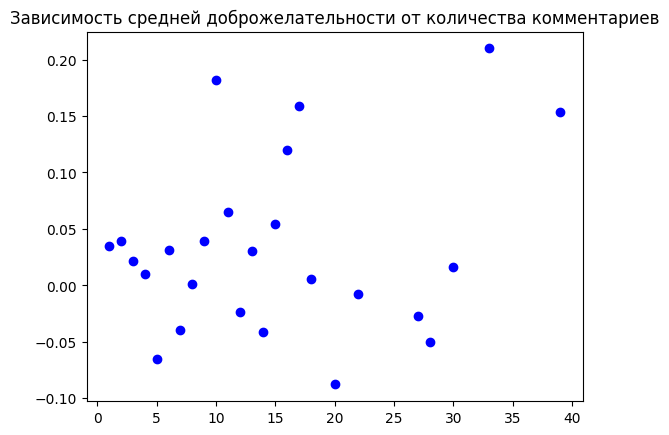

In [ ]:
dff = df_authors[(df_authors[('Сообщение', 'count')] > 0) & (df_authors[('Доброжелательность', 'mean')] != 0)]
dff = dff.groupby(('Сообщение', 'count')).mean()
x = dff.index.tolist()[:-2] # нормализуем, убрав администраторов сообщества из выборки
y = dff[('Доброжелательность', 'mean')].tolist()[:-2]
plt.plot(x, y, 'bo')
dff = dff.groupby(('Сообщение', 'count')).mean()
plt.title('Зависимость средней доброжелательности от количества комментариев отдельного пользователя')